In [1]:
import os
import cobra
import pandas as pd
import numpy as np

import medusa
from medusa.flux_analysis import flux_balance

from pickle import load

import matplotlib.pylab as plt
import matplotlib
from sklearn.metrics.pairwise import pairwise_distances

In [30]:
# load all ensembles
ensembles = {}
exclude = ['Bacillus megaterium','Stenotrophomonas maltophilia',
           'Gordonia bronchialis','Achromobacter piechaudii',
          'Achromobacter xylosoxidans']
for species_file in os.listdir("../results/deep_ensembles/"):
    species_name = species_file.split(".")[0]
    
    if species_name not in exclude:
        with open("../results/deep_ensembles/"+species_name+".pickle",'rb') as infile:
            ensembles[species_name] = load(infile)

In [3]:
# get predicted flux through biomass in complete media for all ensembles
bm_flux = {}
for species in ensembles.keys():
    if species not in exclude:
        ensemble = ensembles[species]

        # make sure all exchange reactions are open to calculate
        # growth rate in complete media
        ex_rxns = [rxn for rxn in ensemble.base_model.reactions if
                      rxn.id.startswith('EX_')]
        for rxn in ex_rxns:
            rxn.lower_bound = -1000

        bm_flux[species] = flux_balance.optimize_ensemble(
                                ensemble,
                                return_flux = "bio1"
                                )
        bm_flux[species].index = [member.id for member in bm_flux[species].index]

In [31]:
# load the gene essentiality predictions for subsampling
gene_knockout_results = {}    
for fname in os.listdir('../results/gene_knockouts/'):
    species = fname.split('.')[0]
    if species not in exclude:
        frame = pd.read_csv(
            '../results/gene_knockouts/'+species+'.csv',sep=',',index_col=0)

        frame = frame < 1E-6
        frame = frame.loc[(frame == 1).sum(axis=1) != len(frame.columns)]
        frame = frame.loc[(frame == 0).sum(axis=1) < len(frame.columns)]
        gene_knockout_results[species] = frame.T

In [24]:
# test out the subsampling approach for genes here... prototype is in the cell below, which might work
# but will have long runtime.
gene_knockout_results[species].sum() > 0 & (gene_knockout_results[species].sum() < len(gene_knockout_results[species].index))

435832.3.peg.1882    True
435832.3.peg.1056    True
435832.3.peg.180     True
435832.3.peg.2004    True
435832.3.peg.1409    True
435832.3.peg.1748    True
435832.3.peg.1617    True
435832.3.peg.37      True
435832.3.peg.1239    True
435832.3.peg.541     True
435832.3.peg.159     True
435832.3.peg.1593    True
435832.3.peg.1883    True
435832.3.peg.1223    True
435832.3.peg.1329    True
435832.3.peg.1909    True
435832.3.peg.128     True
435832.3.peg.859     True
435832.3.peg.129     True
435832.3.peg.296     True
435832.3.peg.641     True
435832.3.peg.1013    True
435832.3.peg.457     True
435832.3.peg.1128    True
dtype: bool

In [40]:
# Extract the features and states from the ensemble for subsampling
# at given intervals for n_draws at each interval
interval = 20
subsample_sizes = list(range(interval,1001,interval))
n_draws = 1000
feature_plotframes = {}
bm_flux_mean_plotframes = {}
bm_flux_std_plotframes = {}
gene_plotframes = {}

for species in gene_knockout_results.keys():
    print('Subampling for ' + species)
    ensemble = ensembles[species]
        
    # Grab the features and states for the ensemble and convert to a dataframe
    feature_dict = {}
    for feature in ensemble.features:
        feature_dict[feature.id] = feature.states
    feature_frame = pd.DataFrame.from_dict(feature_dict)

    # Convert to a boolean dataframe for faster computation
    # (0 values become False, all others become True (i.e. active features))
    feature_frame = feature_frame.astype(bool)
    
    counts = {}
    gene_counts = {}
    bm_flux_means = {}
    bm_flux_std = {}
    species_mean = bm_flux[species]['bio1'].mean()
    for sample_size in subsample_sizes:

        # randomly select a number of samples (sample_size) n_draw times
        counts[sample_size] = []
        gene_counts[sample_size] = []
        bm_flux_means[sample_size] = []
        bm_flux_std[sample_size] = []
        for i in range(0,n_draws):
            draw = feature_frame.sample(n=sample_size, replace=True)
            
            # get the number of features with a non-zero entry
            # i.e. those that are active in this subsample
            non_redundant = (draw.sum(axis=0) > 0).sum()
            counts[sample_size].append(non_redundant)
            
            # extract the biomass flux predictions for this draw as well
            bm_flux_sample = bm_flux[species].loc[draw.index,'bio1']
            # normalize the mean/std subsample by the population mean
            bm_flux_means[sample_size].append(bm_flux_sample.mean()/species_mean)
            bm_flux_std[sample_size].append(bm_flux_sample.std()/species_mean)
            
            # extract the gene essentiality predictions from the draw
            gene_sample = gene_knockout_results[species].loc[draw.index]
            # count the number of genes with more than one unique value from the subsample
            gene_counts[sample_size].append(sum(
                (gene_sample.sum()) > 0 & 
                (gene_sample.sum() < len(gene_sample.index))))
            
    # Convert the subsampling results into a dataframe
    counts_frame = pd.DataFrame.from_dict(counts)
    gene_counts_frame = pd.DataFrame.from_dict(gene_counts)
    bm_flux_mean_frame = pd.DataFrame.from_dict(bm_flux_means)
    bm_flux_std_frame = pd.DataFrame.from_dict(bm_flux_std)

    # collapse feature subsampling to mean and standard deviation
    feature_plotframes[species] = pd.DataFrame()
    feature_plotframes[species]['mean'] = counts_frame.mean(axis=0)
    feature_plotframes[species]['standard deviation'] = counts_frame.std(axis=0)
    
    # collapse gene essentiality subsampling to mean and standard deviation
    gene_plotframes[species] = pd.DataFrame()
    gene_plotframes[species]['mean'] = gene_counts_frame.mean(axis=0)
    gene_plotframes[species]['standard deviation'] = gene_counts_frame.std(axis=0)
    
    
    # Do the same for the biomass flux mean/std (Careful -- these
    # are now means of means and means, std of means, means of std, and std of std)
    bm_flux_mean_plotframes[species] = pd.DataFrame()
    bm_flux_mean_plotframes[species]['mean'] = bm_flux_mean_frame.mean(axis=0)
    bm_flux_mean_plotframes[species]['standard_deviation'] = bm_flux_mean_frame.std(axis=0)
    
    bm_flux_std_plotframes[species] = pd.DataFrame()
    bm_flux_std_plotframes[species]['mean'] = bm_flux_std_frame.mean(axis=0)
    bm_flux_std_plotframes[species]['standard_deviation'] = bm_flux_std_frame.std(axis=0)

Subampling for Ralstonia solanacearum
Subampling for Pseudomonas mendocina
Subampling for Neisseria mucosa
Subampling for Neisseria flavescens
Subampling for Listeria monocytogenes
Subampling for Streptococcus equinus
Subampling for Flavobacterium johnsoniae
Subampling for Pseudomonas putida
Subampling for Corynebacterium efficiens
Subampling for Streptococcus vestibularis
Subampling for Chryseobacterium gleum
Subampling for Streptococcus mitis
Subampling for Neisseria meningitidis
Subampling for Listeria seeligeri
Subampling for Staphylococcus aureus
Subampling for Enterococcus faecalis
Subampling for Streptococcus gallolyticus
Subampling for Streptococcus oralis
Subampling for Haemophilus influenzae
Subampling for Staphylococcus epidermidis
Subampling for Pseudomonas stutzeri
Subampling for Sphingobacterium spiritivorum
Subampling for Bacillus pumilus
Subampling for Aeromonas salmonicida
Subampling for Haemophilus parasuis
Subampling for Streptococcus pneumoniae
Subampling for Staphy

In [41]:
gene_plotframes

{'Aeromonas salmonicida':        mean  standard deviation
 20    3.993            0.314722
 40    4.100            0.309994
 60    4.130            0.336472
 80    4.178            0.382704
 100   4.218            0.413094
 120   4.279            0.448732
 140   4.270            0.444182
 160   4.303            0.459785
 180   4.389            0.487767
 200   4.402            0.490547
 220   4.426            0.494741
 240   4.450            0.497743
 260   4.444            0.497103
 280   4.490            0.500150
 300   4.518            0.499926
 320   4.569            0.495464
 340   4.575            0.494590
 360   4.605            0.489095
 380   4.617            0.486362
 400   4.622            0.485130
 420   4.674            0.468982
 440   4.687            0.463946
 460   4.707            0.455366
 480   4.705            0.456271
 500   4.694            0.461060
 520   4.740            0.438854
 540   4.742            0.437753
 560   4.754            0.430894
 580   4.787      

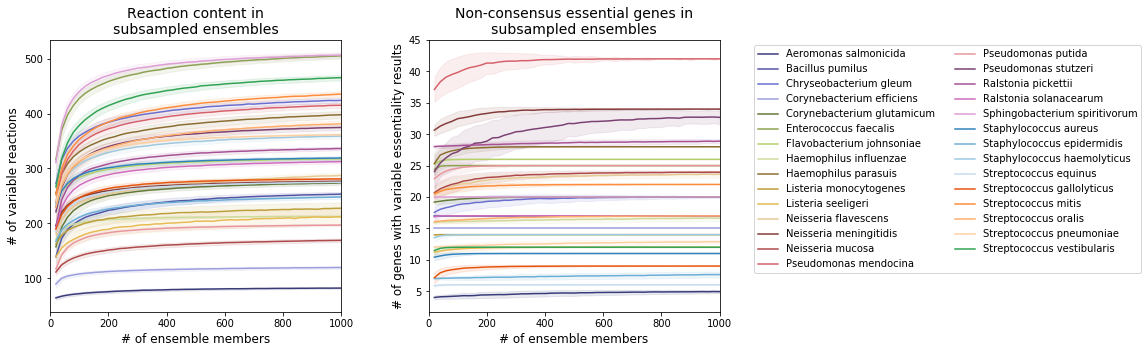

In [69]:
# tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
#             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
#             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
#             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
#             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# for i in range(len(tableau20)):
#         r, g, b = tableau20[i]
#         tableau20[i] = (r/255, g/255, b/255)
tab20b = matplotlib.cm.get_cmap(name='tab20b', lut=None)
tab20c = matplotlib.cm.get_cmap(name='tab20c', lut=None)        

tableau20 = list(tab20b.colors)
tableau20.extend(list(tab20c.colors))

color_dict = {}
# sort the species names so they are plotted in order by color
species_names = list(feature_plotframes.keys())
species_names = sorted(species_names)
for i in range(0,len(feature_plotframes.keys())):
    color_dict[species_names[i]] = tableau20[i]

fig,ax = plt.subplots(1,2)
for species in species_names:
    plotframe = feature_plotframes[species]
    ax[0].plot(plotframe.index,plotframe['mean'],label=species,color=color_dict[species])
    ax[0].fill_between(plotframe.index,
                plotframe['mean']+plotframe['standard deviation'],
                plotframe['mean']-plotframe['standard deviation'],
               alpha = 0.1,color=color_dict[species])
ax[0].set_title('Reaction content in\nsubsampled ensembles',fontsize=14)
ax[0].set_xlabel('# of ensemble members',fontsize=12)
ax[0].set_ylabel('# of variable reactions',fontsize=12)
ax[0].set_xlim([0,1000])

for species in species_names:
    plotframe = gene_plotframes[species]
    ax[1].plot(plotframe.index,plotframe['mean'],label=species,color=color_dict[species])
    ax[1].fill_between(plotframe.index,
                plotframe['mean']+plotframe['standard deviation'],
                plotframe['mean']-plotframe['standard deviation'],
               alpha = 0.1,color=color_dict[species])
ax[1].set_title('Non-consensus essential genes in\nsubsampled ensembles',fontsize=14)
ax[1].set_xlabel('# of ensemble members',fontsize=12)
ax[1].set_ylabel('# of genes with variable essentiality results',fontsize=12)
ax[1].set_xlim([0,1000])


# for species in species_names:
#     plotframe = bm_flux_mean_plotframes[species]
#     #ax[1].plot(plotframe.index,plotframe['mean'], label=species, color=color_dict[species])
#     ax[1].plot(plotframe.index,plotframe['standard_deviation'], label=species, color=color_dict[species])
#     #ax[1].fill_between(plotframe.index,
#     #            plotframe['mean']+plotframe['standard_deviation'],
#     #            plotframe['mean']-plotframe['standard_deviation'],
#     #           alpha = 0.1, color=color_dict[species])
# ax[1].set_title('Mean flux through biomass',fontsize=14)
# ax[1].set_xlabel('# of ensemble members',fontsize=12)
# ax[1].set_ylabel('Fraction of entire\nensemble mean',fontsize=12)
# ax[1].set_xlim([0,1001])

# for species in bm_flux_std_plotframes.keys():
#     plotframe = bm_flux_std_plotframes[species]
#     #ax[2].plot(plotframe.index,plotframe['mean'], label=species, color=color_dict[species])
#     ax[2].plot(plotframe.index,plotframe['standard_deviation'], label=species, color=color_dict[species])
#     #ax[2].fill_between(plotframe.index,
#     #            plotframe['mean']+plotframe['standard_deviation'],
#     #            plotframe['mean']-plotframe['standard_deviation'],
#     #           alpha = 0.2, color=color_dict[species])
# ax[2].set_title('Standard deviation of\nflux through biomass',fontsize=14)
# ax[2].set_xlabel('# of ensemble members',fontsize=12)
# ax[2].set_ylabel('Standard deviation as fraction \n of mean for entire ensemble',fontsize=12)
# ax[2].set_xlim([0,1001])

ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))
ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))
ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))


fig.set_size_inches(12,5)
leg = ax[1].legend(ax[1].get_legend_handles_labels()[0],
          ax[1].get_legend_handles_labels()[1],
          loc='upper left',
          bbox_to_anchor=(1.1,1),
          ncol=2,
          fontsize=10)
#fig.tight_layout()
#fig.subplots_adjust(bottom=0.5)
fig.subplots_adjust(wspace=0.3)
fig.savefig('../results/ensemble_subsampling.svg',bbox_inches="tight",bbox_extra_artists=(leg,))
fig.savefig('../results/ensemble_subsampling.png',bbox_inches="tight",bbox_extra_artists=(leg,))

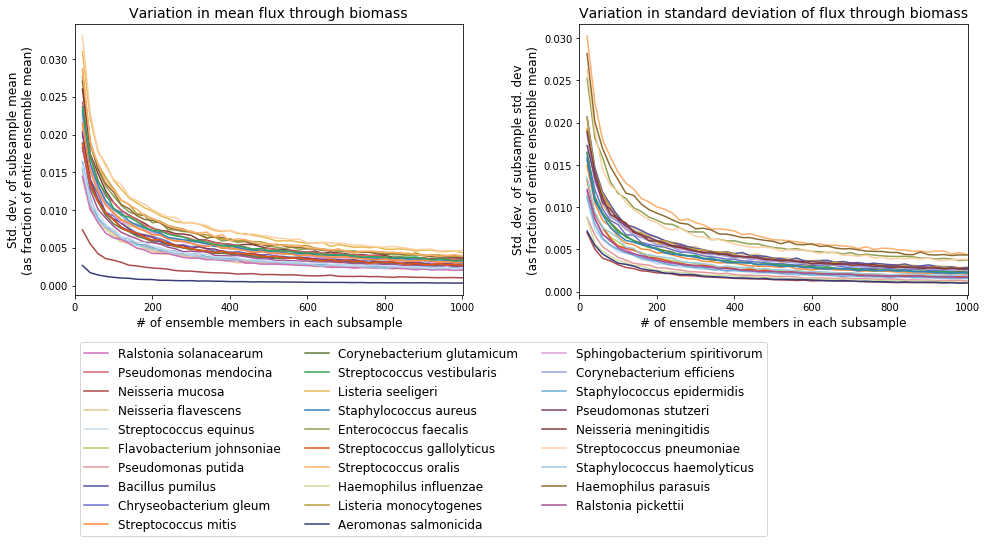

In [55]:
tab20b = matplotlib.cm.get_cmap(name='tab20b', lut=None)
tab20c = matplotlib.cm.get_cmap(name='tab20c', lut=None)        

tableau20 = list(tab20b.colors)
tableau20.extend(list(tab20c.colors))

color_dict = {}
# sort the species names so they are plotted in order by color
species_names = list(feature_plotframes.keys())
species_names = sorted(species_names)
for i in range(0,len(feature_plotframes.keys())):
    color_dict[species_names[i]] = tableau20[i]

fig,ax = plt.subplots(1,2)
for species in species_names:
    plotframe = bm_flux_mean_plotframes[species]
    #ax[1].plot(plotframe.index,plotframe['mean'], label=species, color=color_dict[species])
    ax[0].plot(plotframe.index,plotframe['standard_deviation'], label=species, color=color_dict[species])
    #ax[1].fill_between(plotframe.index,
    #            plotframe['mean']+plotframe['standard_deviation'],
    #            plotframe['mean']-plotframe['standard_deviation'],
    #           alpha = 0.1, color=color_dict[species])
ax[0].set_title('Variation in mean flux through biomass',fontsize=14)
ax[0].set_xlabel('# of ensemble members in each subsample',fontsize=12)
ax[0].set_ylabel('Std. dev. of subsample mean\n(as fraction of entire ensemble mean)',fontsize=12)
ax[0].set_xlim([0,1001])

for species in bm_flux_std_plotframes.keys():
    plotframe = bm_flux_std_plotframes[species]
    #ax[2].plot(plotframe.index,plotframe['mean'], label=species, color=color_dict[species])
    ax[1].plot(plotframe.index,plotframe['standard_deviation'], label=species, color=color_dict[species])
    #ax[2].fill_between(plotframe.index,
    #            plotframe['mean']+plotframe['standard_deviation'],
    #            plotframe['mean']-plotframe['standard_deviation'],
    #           alpha = 0.2, color=color_dict[species])
ax[1].set_title('Variation in standard deviation of flux through biomass',fontsize=14)
ax[1].set_xlabel('# of ensemble members in each subsample',fontsize=12)
ax[1].set_ylabel('Std. dev. of subsample std. dev\n(as fraction of entire ensemble mean)',fontsize=12)
ax[1].set_xlim([0,1001])

ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))
ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))
ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))


fig.set_size_inches(16,5)
leg = ax[1].legend(ax[1].get_legend_handles_labels()[0],
          ax[1].get_legend_handles_labels()[1],
          loc='upper right',
          bbox_to_anchor=(0.5,-0.15),
          ncol=3,
          fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(bottom=0.5)
fig.subplots_adjust(wspace=0.3)
fig.savefig('../results/ensemble_biomass_subsampling.svg',bbox_inches="tight",bbox_extra_artists=(leg,))
fig.savefig('../results/ensemble_biomass_subsampling.png',bbox_inches="tight",bbox_extra_artists=(leg,))